# Spike-LFP Coupling

Neural oscillations affect the spike timing of neurons. Identifying how neurons fire in relation to oscillations can help uncover which neurons participate in an oscillation, and and to what degree. This notebook will demonstrate how to quantify how the spike timing of neurons relates to underlying oscillations. Specifically, this notebook shows how to:
1. Filter data into a frequency band
2. Extract phase information
3. Visualize spike-lfp coupling
4. Quantify spike-lfp coupling

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt

Let's start by simulating an oscillation, and a neuron that tends to fire at the trough of the oscillation. We'll plot the spikes as vertical lines over the lfp.

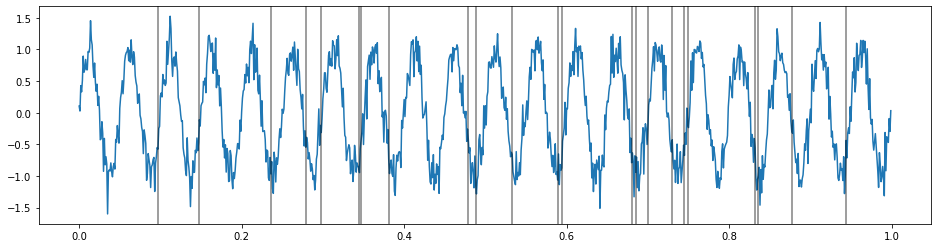

In [43]:
#Simulate LFP
fs = 1000
times = np.arange(0, 1, 1/fs)
freq = 20
lfp = np.sin(2 * np.pi * times[:] * freq)
noise = np.random.normal(0, .2, size=times.shape)
lfp += noise
plt.figure(figsize=(16, 4))
plt.plot(times, lfp)
#Simulate neuron
spike_times = []
lfp_min0 = lfp-np.min(lfp)+.001
for i in range(0,len(times)):
    probability = (2 - lfp_min0[i])/20
    if probability > 0:
        sample = np.random.choice([0,1],p=[1-probability, probability])
        if sample==1:
            spike_times.append(times[i])
for spike in spike_times:
    plt.axvline(spike, color='black', alpha=.5)

We'll want to look at how the neuron fires with respect to some particular oscillation, or frequency band. To do so, we need to filter the lfp signal into a range of interest. Let's start by filtering in the beta (12-32Hz) band.

## Filtering

Filtering is used to emphasize or demphasize activity in particular frequencies in time-series. Common applications of filters to neural electrophysiological data are to remove 60Hz line noise, remove low frequency activity for spike detection / remove high frequency activity for LFP analyses, and to isolate specific oscillations. 


There are many commonly used filter designs, with customizable parameters. The goal of each filter is to maximize the attennuation of unwanted frequencies, which can be best achieved using filters with a narrow transition band in frequency space. However, these "sharp" filters produce stronger signal distortions and ringing artifacts. Therefore, choices in filter design often come down to this trade-off [[1]](#References). Additionally, higher filter orders effectively decrease the time resolution while increasing the frequency resolution. Here, we'll use a butterworth filter, which is maximally uniform in how it affects the magnitude of activity in the filtered frequency range. Additionally, we'll use an order of 4. Feel free to try other filter designs (cheby2, bessel) or orders to see their affects.

Filters are often applied through convolution over the signal. This can distort phase estimation, as convolving in a particular direction will result in a phase shift. To eliminate this shift, filters can be convolved once forwards and then backwards, which we will do with scipy's [filtfilt](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.filtfilt.html) function. 

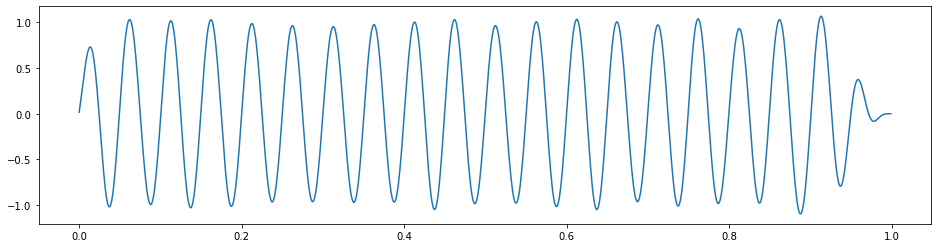

In [60]:
order=4
freq_band = [12, 32]
b, a = butter(order, freq_band, fs=fs, btype='band')
filt_data = filtfilt(b, a, lfp, padtype=None)
plt.figure(figsize=(16,4))
plt.plot(times, filt_data)

As you can see, we've removed a lot of the noise and cleanly uncovered the underlying oscillation. There is one small issue at the ends of the oscillation. 

## References
1. Widmann, A., Schröger, E., & Maess, B. (2015). Digital filter design for electrophysiological data – a practical approach. Journal of Neuroscience Methods, 250, 34–46. https://doi.org/10.1016/J.JNEUMETH.2014.08.002